In [3]:
import pandas as pd
import seaborn as sns
from scipy.stats import norm, lognorm, beta, halfnorm, gmean, gstd
import sqlite3 as sql
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

This notebook develops the pharmacokinetic parameter priors used in the PFAS analysis

# Clearance

In [2]:
df_all = pd.read_csv('../auxiliary/ATSDR_summary.csv')
df = df_all.copy()
df['CLC'] = df['clearance']/1000 # Convert ml/kg/d --> L/kg/d
df['log_value'] = np.log(df.CLC)
df.head()

,species,route,PFAS,clearance,clearance_units,CLC,log_value
0,monkey,iv,PFOA,12.40,ml/d/kg,0.01240,-4.390059
1,monkey,iv,PFOA,5.30,ml/d/kg,0.00530,-5.240048
2,monkey,iv,PFOS,1.10,ml/d/kg,0.00110,-6.812445
3,monkey,iv,PFOS,1.65,ml/d/kg,0.00165,-6.406980
4,monkey,iv,PFHxA,569.00,ml/d/kg,0.56900,-0.563875


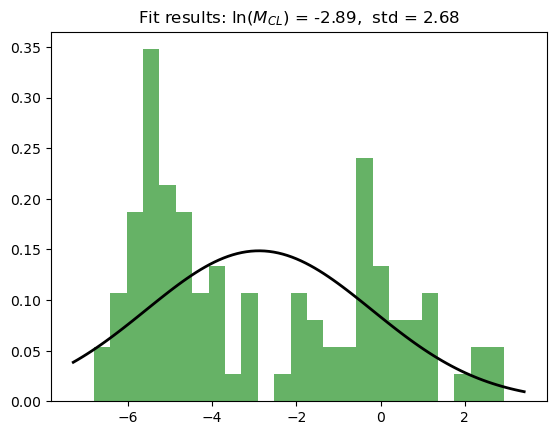

In [29]:
mu, std = norm.fit(df.log_value)
# Plot the histogram.
plt.hist(df.log_value, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: ln($M_{CL}$) = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

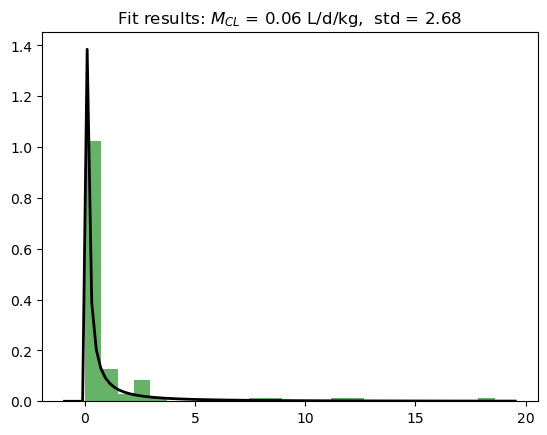

In [30]:
# Now check the log-normal distribution against the reported values for clearance
plt.hist(df.CLC, bins=25, density=True, alpha=0.6, color='g')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = lognorm.pdf(x, scale=np.exp(mu), s=std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: $M_{CL}$ = %.2f L/d/kg,  std = %.2f" % (np.exp(mu), std)
plt.title(title)

plt.show()

# Volume of distribution

0.22175 -1.5062046577924482 4.5
[3.27685092e-05 2.21750000e-01 1.50061946e+03]


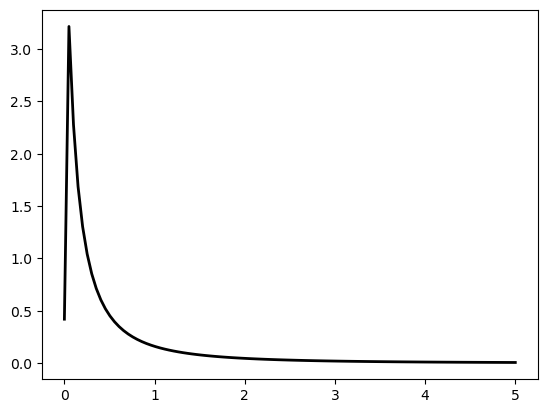

In [15]:
GM = np.mean([0.2, 0.2, 0.287, 0.2])
GSD = 4.5
print(GM, np.log(GM), GSD)
xmin, xmax = 0.001, 5
x = np.linspace(xmin, xmax, 100)
p = lognorm.pdf(x, s=np.log(GSD), scale=GM)
plt.plot(x, p, 'k', linewidth=2)

# Look at quantiles to see if they make sense for a range of possible Vd
print(lognorm.ppf([0.025, 0.5, 0.975], s=GSD, scale=GM))

# Absorption

From ATSDR, absorption half-life of PFAS is < 1 hour where:

$t_{1/2} = \frac{ln(2)}{k_a}$

In [40]:
abs_halft = 0.206 # Average absorption half-life (hours)
ka = np.log(2)/(abs_halft/24)
print('k_abs (1/d): %0.3f'%ka)

k_abs (1/d): 80.755


# PK parameter priors summary

Median and 95 percentiles for the prior distributions used in this study.

In [16]:
q = [0.025, 0.5, 0.975]
#q = [0.03, 0.5, 0.97]
# k12
print('k12')
print(lognorm.ppf(q, scale=0.01, s=1.5))

# R
print('R')
print(lognorm.ppf(q, scale=100, s=1.5))

# ka
print('ka')
print(lognorm.ppf(q, scale=81, s=0.25))

# Vd
print('Vd')
print(lognorm.ppf(q, scale=0.222, s=1.5))

# CLC
print('CLC')
print(lognorm.ppf(q, scale=0.06, s=2.68))

# fa
print('fa')
print(beta.ppf(q, a=6, b=1.5))

# half-t
N = 1000000
CLC = lognorm(scale=0.06, s=2.68).rvs(N)
Vd = lognorm(scale=0.222, s=1.5).rvs(N)
halft = np.log(2)*Vd/CLC
print('half-t')
print(np.quantile(halft, q))

k12
[0.00052869 0.01       0.18914824]
R
[   5.28685848  100.         1891.48244455]
ka
[ 49.62318473  81.         132.21642335]
Vd
[0.01173683 0.222      4.19909103]
CLC
[3.14001060e-04 6.00000000e-02 1.14649294e+01]
fa
[0.4720218  0.82724859 0.98286093]
half-t
[6.32129992e-03 2.58072621e+00 1.08260631e+03]
